Applicazione della tecnica del transfer learning per sfruttare
le performance di un modello standard, pre-addestrato su un compito generico,
su un nuovo compito.

Partendo dal modello [Xception](https://arxiv.org/abs/1610.02357) (una evoluzione del modello Inception)
addestrato sul dataset ImageNet composto da oltre 1.3M immagini organizzate
su 1000 classi, si effettuerà il transfer learning per riaddestrare parzialmente
il modello in modo da farlo operare su un altro dataset, il "Cats vs Dogs".

Inoltre vedremo un esempio di data-augmentation per incrementare l'efficacia
del dataset utilizzato.

In [1]:
# importazione librerie necessarie
import tensorflow as tf
import tensorflow_datasets as tfds # pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# evitiamo di far vedere la progress-bar di
# avanzamento del download del dataset
tfds.disable_progress_bar()

# utilizziamo i dataset di TensorFlow per
# gestire i dati del nuovo dataset
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Numero di esempi di addestramento: %d" % tf.data.experimental.cardinality(train_ds))
print("Numero di esempi di validazione: %d" % tf.data.experimental.cardinality(validation_ds))
print("Numero di esempi di test: %d" % tf.data.experimental.cardinality(test_ds))

Numero di esempi di addestramento: 9305
Numero di esempi di validazione: 2326
Numero di esempi di test: 2326


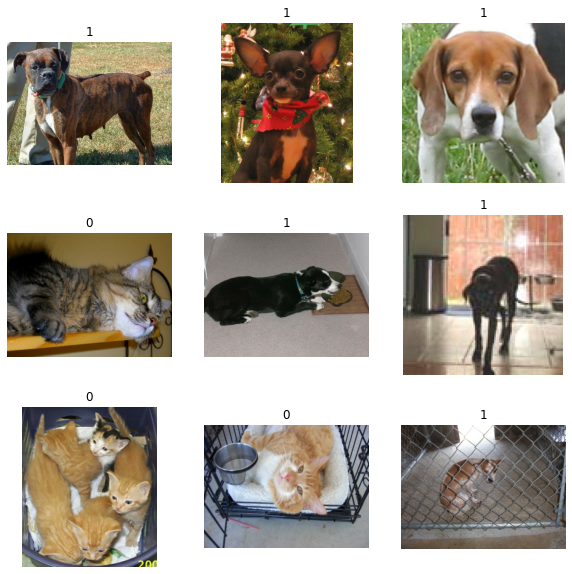

In [3]:
# visualizzazione di 9 immagini prese
# dal dataset di addestramento e disposte
# in una griglia 3x3
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
size = (150, 150) # dimensione delle immagini in input al modello Xception

# resize delle immagini del dataset nelle dimensioni
# previste dal modello Xception

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
batch_size = 32

# con il metodo [cache()] impostiamo un caching automatico degli esempi
# il metodo [prefetch()] permette a TF di scaricare
# e preparare i dati per il successivo batch di esempi
# durante l'addestramento del batch attuale
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [6]:
# incremento degli esempi disponibili
# tramite modifica delle immagini originali
# tramite il flip orizzontale ed una rotazione
# random pari al 10% di 360° (quindi da -36° fino
# a 36°)
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

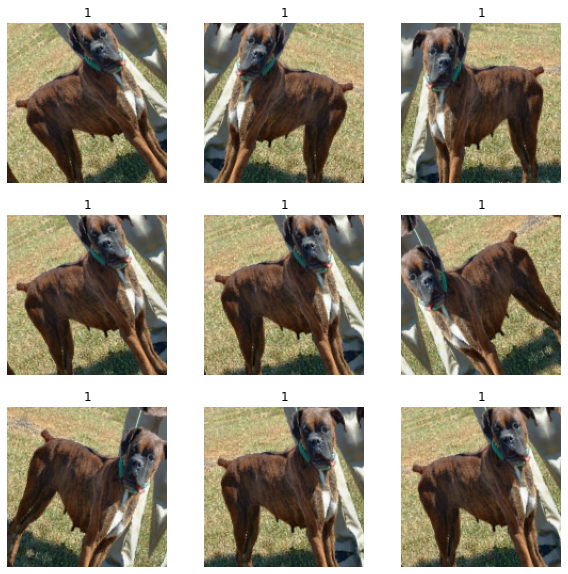

In [7]:
# recupero un'immagine dal dataset di addestramento
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    # eseguo la data-augmentation 9 volte
    # per generare nuove 9 immagini partendo
    # da una del dataset di addestramento
    # per poi visualizzarle in una griglia 3x3
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [8]:
# recuro del modello preaddestrato
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # caricamento dei pesi addestrati su ImageNet
    input_shape=(150, 150, 3),
    include_top=False, # non include gli ultimi layer (di classificazione) del modello
)

# blocco dell'addestramento
# (i pesi non sono modificabili)
base_model.trainable = False

# creazione di un nuovo modello che
# sfrutta Xception preaddestrato

inputs = tf.keras.layers.Input(shape=(150, 150, 3))

# applicazione della data-augmentation sugli input
x = data_augmentation(inputs)

# Il modello preaddestrato Xception richiede che l'input sia
# normalizzato nell'intervallo (-1., +1.)
# il layer di normalizzazione esegue appunto
# outputs = (inputs - mean) / sqrt(var)

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [9]:
# compilazione del modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 50s 153ms/step - loss: 0.1650 - binary_accuracy: 0.9281 - val_loss: 0.0866 - val_binary_accuracy: 0.9682

In [13]:
# riaddestriamo tutto il modello per un fine-tuning
# finale con un learning rate molto basso.
# per fare questo è necessario sbloccare il modello
# base (base_model)

base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

# nb. ricompilare il modello non ne resetta
# i pesi - la compilazione serve a rendere
# un modello addestrabile, definendo
# l'ottimizzatore, le metriche e la funzione
# di costo da utilizzare

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  